# Import Libraries

In [1]:
# Common imports
import os
import numpy as np

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

In [2]:
# TensorFlow imports
# may differs from version to versions

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

## Set Some Parameters

In [3]:
# Dataset information

# Test dataset is set explicitly, because the amount of data is very small
train_aug_image_folder = os.path.join('datasets', 'face_dataset_train_aug_images')
train_image_folder = os.path.join('datasets', 'face_dataset_train_images')
test_image_folder = os.path.join('datasets', 'face_dataset_test_images')
img_height, img_width = 250, 250  # size of images
num_classes = 2  # me - not_me

# Training settings
validation_ratio = 0.15  # 15% for the validation
batch_size = 16

AUTOTUNE = tf.data.AUTOTUNE

## Create Dataset

### Read datasets from folders

In [4]:
# Train and validation sets of initial dataset
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_image_folder,
    validation_split=validation_ratio,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    label_mode='categorical',
    batch_size=batch_size,
    shuffle=True)

val_ds = keras.preprocessing.image_dataset_from_directory(
    train_image_folder,
    validation_split=validation_ratio,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True)

Found 195 files belonging to 2 classes.
Using 166 files for training.
Found 195 files belonging to 2 classes.
Using 29 files for validation.


In [5]:
# Train and validation sets of augmented dataset
train_aug_ds = keras.preprocessing.image_dataset_from_directory(
    train_aug_image_folder,
    validation_split=validation_ratio,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    label_mode='categorical',
    batch_size=batch_size,
    shuffle=True)

val_aug_ds = keras.preprocessing.image_dataset_from_directory(
    train_aug_image_folder,
    validation_split=validation_ratio,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True)

Found 975 files belonging to 2 classes.
Using 829 files for training.
Found 975 files belonging to 2 classes.
Using 146 files for validation.


In [6]:
test_ds = keras.preprocessing.image_dataset_from_directory(
    test_image_folder,
    image_size=(img_height, img_width),
    label_mode='categorical',
    shuffle=False)

Found 20 files belonging to 2 classes.


In [7]:
class_names = test_ds.class_names
class_names

['me', 'not_me']

# Build The Model 

In [8]:
# Here I experiment with different models
# Each model is represented in it own cells

## VGG16

In [9]:
base_model = keras.applications.vgg16.VGG16(weights='imagenet',
                                            include_top=False,  # without dense part of the network
                                            input_shape=(img_height, img_width, 3))

# Set layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the convolutional layers of VGG16
flatten = keras.layers.Flatten()(base_model.output)
dense_4096_1 = keras.layers.Dense(4096, activation='relu')(flatten)
dense_4096_2 = keras.layers.Dense(4096, activation='relu')(dense_4096_1)
output = keras.layers.Dense(num_classes, activation='sigmoid')(dense_4096_2)

VGG16 = keras.models.Model(inputs=base_model.input,
                           outputs=output,
                           name='VGG16')
VGG16.summary()

Model: "VGG16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250, 250, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 250, 250, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 250, 250, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 125, 125, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 125, 125, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 125, 125, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 62, 62, 128)       0     

## ResNet50

In [10]:
base_model = keras.applications.ResNet50(weights='imagenet',
                                         include_top=False,  # without dense part of the network
                                         input_shape=(img_height, img_width, 3))

# Set layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of ResNet
global_avg_pooling = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(num_classes, activation='sigmoid')(global_avg_pooling)

ResNet50 = keras.models.Model(inputs=base_model.input,
                              outputs=output,
                              name='ResNet50')
ResNet50.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 125, 125, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 125, 125, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

## ResNet152

In [11]:
base_model = keras.applications.ResNet152(weights='imagenet',
                                          include_top=False,  # without dense part of the network
                                          input_shape=(img_height, img_width, 3))

# Set layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of ResNet
global_avg_pooling = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(num_classes, activation='sigmoid')(global_avg_pooling)

ResNet152 = keras.models.Model(inputs=base_model.input,
                               outputs=output,
                               name='ResNet152')
ResNet152.summary()

Model: "ResNet152"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 256, 256, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 125, 125, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 125, 125, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

## Xception

In [12]:
base_model = keras.applications.Xception(weights='imagenet',
                                         include_top=False,  # without dense part of the network
                                         input_shape=(img_height, img_width, 3))

# Set layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of Xception
global_avg_pooling = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(num_classes, activation='sigmoid')(global_avg_pooling)

Xception = keras.models.Model(inputs=base_model.input,
                              outputs=output,
                              name='Xception')
Xception.summary()

Model: "Xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 124, 124, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 124, 124, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 124, 124, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

## MobileNet

In [13]:
base_model = keras.applications.MobileNet(weights='imagenet',
                                          include_top=False,  # without dense part of the network
                                          input_shape=(img_height, img_width, 3))

# Set layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of MobileNet
global_avg_pooling = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(num_classes, activation='sigmoid')(global_avg_pooling)

MobileNet = keras.models.Model(inputs=base_model.input,
                               outputs=output,
                               name='MobileNet')
MobileNet.summary()

Model: "MobileNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 250, 250, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 125, 125, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 125, 125, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 125, 125, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 125, 125, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 125, 125, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 125, 125, 32)      0 

# Training

Choose one of the models in next cell. Possible options:
- VGG16
- ResNet50
- ResNet152
- Xception
- MobileNet

Then choose if you want to train CNN on augmented dataset. 
- If you choose `train_on_aug = True` CNN will train on augmented dataset, 
- if `train_on_aug = False` on base dataset (195 images).

In [18]:
face_classifier = MobileNet
face_classifier.summary()  # to check that model is choosen correctly

train_on_aug = False  # train on augmented dataset

if train_on_aug:
    train_ds = train_aug_ds
    val_ds = val_aug_ds

if train_on_aug:
    name_to_save = f"models/face_classifier_{face_classifier.name}_aug.h5"
else:
    name_to_save = f"models/face_classifier_{face_classifier.name}.h5"

Model: "MobileNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 250, 250, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 125, 125, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 125, 125, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 125, 125, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 125, 125, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 125, 125, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 125, 125, 32)      0 

## All models trains in one context, so this part of the code is the same

In [19]:
# ModelCheckpoint to save model in case of interrupting the learning process
checkpoint = ModelCheckpoint(name_to_save,
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)

# EarlyStopping to find best model with a large number of epochs
earlystop = EarlyStopping(monitor='val_loss',
                          restore_best_weights=True,
                          patience=5,  # number of epochs with no improvement after which training will be stopped
                          verbose=1)

callbacks = [earlystop, checkpoint]

In [20]:
face_classifier.compile(loss='categorical_crossentropy',
                        optimizer=keras.optimizers.Adam(learning_rate=0.01),
                        metrics=['accuracy'])

In [21]:
epochs = 50

In [22]:
history = face_classifier.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)

face_classifier.save(name_to_save)

Epoch 1/50
11/11 [==============================] - 3s 178ms/step - loss: 1.5226 - accuracy: 0.5783 - val_loss: 0.6229 - val_accuracy: 0.6897

Epoch 00001: val_loss improved from inf to 0.62287, saving model to models\face_classifier_MobileNet.h5
Epoch 2/50
11/11 [==============================] - 2s 133ms/step - loss: 0.6101 - accuracy: 0.7410 - val_loss: 0.8372 - val_accuracy: 0.7241

Epoch 00002: val_loss did not improve from 0.62287
Epoch 3/50
11/11 [==============================] - 2s 132ms/step - loss: 0.2949 - accuracy: 0.8675 - val_loss: 0.8598 - val_accuracy: 0.7586

Epoch 00003: val_loss did not improve from 0.62287
Epoch 4/50
11/11 [==============================] - 2s 136ms/step - loss: 0.2651 - accuracy: 0.8795 - val_loss: 0.8851 - val_accuracy: 0.7241

Epoch 00004: val_loss did not improve from 0.62287
Epoch 5/50
11/11 [==============================] - 2s 148ms/step - loss: 0.1610 - accuracy: 0.9398 - val_loss: 0.8216 - val_accuracy: 0.7241

Epoch 00005: val_loss did no

# Testing

## Choose a model to test

In [23]:
model_name = 'face_classifier_ResNet50_aug.h5'
face_classifier = keras.models.load_model(f'models/{model_name}')

In [24]:
def test_image_classifier_with_folder(model, path, y_true, img_height=250, img_width=250, class_names=['me', 'not_me']):
    '''
    Read all images from 'path' using tensorflow.keras.preprocessing.image module, 
    than classifies them using 'model' and compare result with 'y_true'.
    Calculate total accuracy based on 'path' test set.

    Parameters:
        model : Image classifier
        path (str): Path to the folder with images you want to test classifier on 
        y_true : True label of the images in the folder. Must be in 'class_names' list
        img_height (int): The height of the image that the classifier can process 
        img_width (int): The width of the image that the classifier can process
        class_names (array-like): List of class names 

    Returns:
        None
    '''
    num_classes = len(class_names)  # Number of classes
    total = 0  # number of images total
    correct = 0  # number of images classified correctly

    for filename in os.listdir(path):
        # read each image in the folder and classifies it
        test_path = os.path.join(path, filename)
        test_image = keras.preprocessing.image.load_img(
            test_path, target_size=(img_height, img_width, 3))
        # from image to array, can try type(test_image)
        test_image = keras.preprocessing.image.img_to_array(test_image)
        # shape from (250, 250, 3) to (1, 250, 250, 3)
        test_image = np.expand_dims(test_image, axis=0)
        result = model.predict(test_image)

        y_pred = class_names[np.array(result[0]).argmax(
            axis=0)]  # predicted class
        iscorrect = 'correct' if y_pred == y_true else 'incorrect'
        print('{} - {}'.format(iscorrect, filename))
        for index in range(num_classes):
            print("\t{:6} with probabily of {:.2f}%".format(
                class_names[index], result[0][index] * 100))

        total += 1
        if y_pred == y_true:
            correct += 1

    print("\nTotal accuracy is {:.2f}% = {}/{} samples classified correctly".format(
        correct/total*100, correct, total))

In [25]:
test_image_classifier_with_folder(face_classifier,
                                  'datasets/face_dataset_test_images/me',
                                  y_true='me')

correct - me_(12).jpg
	me     with probabily of 98.30%
	not_me with probabily of 3.31%
correct - me_(14).jpg
	me     with probabily of 100.00%
	not_me with probabily of 0.01%
incorrect - me_(27).jpg
	me     with probabily of 14.87%
	not_me with probabily of 95.01%
correct - me_(31).jpg
	me     with probabily of 98.12%
	not_me with probabily of 7.14%
correct - me_(36).jpg
	me     with probabily of 99.90%
	not_me with probabily of 0.13%
correct - me_(44).jpg
	me     with probabily of 99.98%
	not_me with probabily of 0.16%
correct - me_(53).jpg
	me     with probabily of 98.71%
	not_me with probabily of 16.32%
correct - me_(58).jpg
	me     with probabily of 99.33%
	not_me with probabily of 1.76%
incorrect - me_(69).jpg
	me     with probabily of 60.93%
	not_me with probabily of 73.47%
correct - me_(8).jpg
	me     with probabily of 98.79%
	not_me with probabily of 0.75%

Total accuracy is 80.00% = 8/10 samples classified correctly


In [26]:
test_image_classifier_with_folder(face_classifier,
                                  'datasets/face_dataset_test_images/not_me',
                                  y_true='not_me')

incorrect - brother_(16).jpg
	me     with probabily of 48.94%
	not_me with probabily of 35.39%
correct - brother_(2).jpg
	me     with probabily of 25.58%
	not_me with probabily of 74.95%
correct - father_(2).jpg
	me     with probabily of 0.43%
	not_me with probabily of 99.71%
correct - father_(5).jpg
	me     with probabily of 1.19%
	not_me with probabily of 99.71%
correct - mother_(20).jpg
	me     with probabily of 0.49%
	not_me with probabily of 99.93%
correct - mother_(5).jpg
	me     with probabily of 1.47%
	not_me with probabily of 99.54%
correct - other.jpg
	me     with probabily of 0.29%
	not_me with probabily of 99.96%
correct - sister_(2).jpg
	me     with probabily of 0.04%
	not_me with probabily of 99.98%
correct - sister_(44).jpg
	me     with probabily of 0.00%
	not_me with probabily of 100.00%
correct - sister_(47).jpg
	me     with probabily of 0.00%
	not_me with probabily of 100.00%

Total accuracy is 90.00% = 9/10 samples classified correctly


## Test of particular image

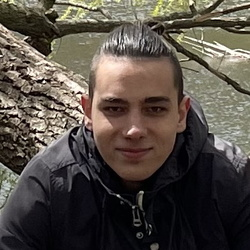

In [27]:
test_path = 'datasets/face_dataset_test_images/me/me_(31).jpg'
test_image = keras.preprocessing.image.load_img(test_path, target_size=(img_height, img_width, 3))
test_image

In [28]:
test_image = keras.preprocessing.image.img_to_array(test_image)  # from image to array
# shape from (250, 250, 3) to (1, 250, 250, 3)
test_image = np.expand_dims(test_image, axis=0)
result = face_classifier.predict(test_image)

for index in range(num_classes):
    print("{:6} with probabily of {:.2f}%".format(
        class_names[index], result[0][index] * 100))

me     with probabily of 98.12%
not_me with probabily of 7.14%


# Plotting

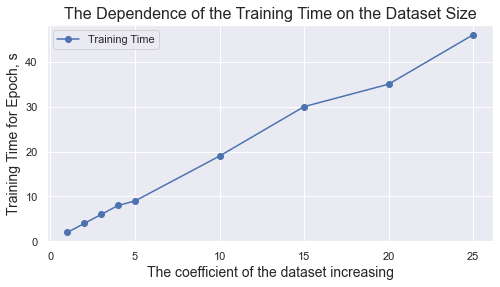

In [29]:
dataset_size = [1, 2, 3, 4, 5, 10, 15, 20, 25]
training_time_per_epoch = [2, 4, 6, 8, 9, 19, 30, 35, 46]


fig = plt.figure(figsize=(8, 4))
plt.plot(dataset_size, training_time_per_epoch, marker='o', label="Training Time")

plt.title("The Dependence of the Training Time on the Dataset Size", fontsize='16')
plt.xlabel("The coefficient of the dataset increasing", fontsize='14')
plt.ylabel("Training Time for Epoch, s", fontsize='14')
plt.legend(loc='best')
plt.savefig('article/img/dataset_size_to_learning_time.jpg')
plt.show()

# The dependence of the training time (per epoch) on the dataset size is linear

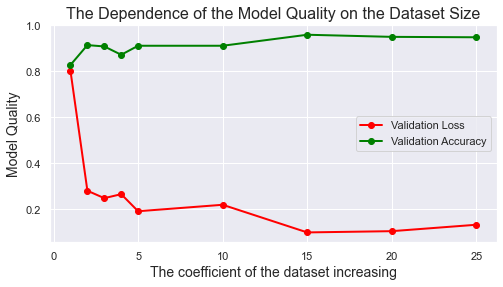

In [30]:
dataset_size = [1, 2, 3, 4, 5, 10, 15, 20, 25]
val_loss = [0.8011, 0.2802, 0.2479, 0.2653, 0.191, 0.2191, 0.09886, 0.10429, 0.1322]
val_accuracy = [0.8276, 0.9138, 0.908, 0.8718, 0.911, 0.911, 0.9589, 0.9497, 0.9479]


fig = plt.figure(figsize=(8, 4))
plt.plot(dataset_size, val_loss, c="red", linewidth=2, marker='o', label="Validation Loss")
plt.plot(dataset_size, val_accuracy, c="green", linewidth=2, marker='o', label="Validation Accuracy")

plt.title("The Dependence of the Model Quality on the Dataset Size", fontsize='16')
plt.xlabel("The coefficient of the dataset increasing", fontsize='14')
plt.ylabel("Model Quality", fontsize='14')
plt.legend(loc='best')
plt.savefig('article/img/dataset_size_to_model_quality.jpg')
plt.show()